In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
import katdal
import numpy as np
import matplotlib.pylab as plt
import astropy.coordinates as ac
import functools
import healpy as hp
import optparse
import warnings
from matplotlib.backends.backend_pdf import PdfPages
import healpy as hp
from astropy import units as u
from matplotlib.offsetbox import AnchoredText
import time
import pickle
import sys
from datetime import datetime
import json
import katcali
import katcali.visualizer as kv
import katcali.models as km
import katcali.rfi as kr
import katcali.solver as ks
import katcali.io as kio
import katcali.label_dump as kl
import katcali.diode as kd
import katcali.filter as kf
import katcali.beam as kb
from astropy.coordinates import SkyCoord
from astropy import units as u
from scipy.sparse import coo_matrix
import astropy.wcs
from astropy.wcs.utils import skycoord_to_pixel
from astropy.wcs.utils import pixel_to_skycoord
from astropy.io import fits
from astropy.wcs import WCS
from scipy.interpolate import UnivariateSpline
import matplotlib.colors as colors
Tcmb=2.725
k_B = 1.38E-23

In [2]:
print ('start @ ' + time.asctime(time.localtime(time.time())) +'...')

start @ Fri Jul 18 06:37:11 2025...


In [3]:
print  (plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth'])
plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth'] = 14, 1.5, 1.5
#plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth'] = 10.0, 0.8, 1.5
print  (plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth'])

10.0 0.8 1.5
14.0 1.5 1.5


In [4]:
pix_deg=0.3 #0.15 #0.3
std_sigma=4. #2023 #the smaller number will make more data be delated 

ch_plot=3200

p_radec=np.loadtxt('radio_source_fsky.txt')
ptr_pix=np.loadtxt('../level5/desi1_radio_sourceUHF_pix_'+str(pix_deg)+'deg.txt')
ptr_ra_pix,ptr_dec_pix=ptr_pix[:,0],ptr_pix[:,1]

In [5]:
root_list = [
    "level5_1675021905_20250609_150000", "level5_1676313206_20250609_150000", "level5_1677195529_20250609_150000", 
    "level5_1678381591_20250609_150000", "level5_1679605292_20250609_150000", "level5_1675210948_20250609_150000", 
    "level5_1676657789_20250609_150000", "level5_1677777992_20250609_150000", "level5_1678467685_20250609_150000", 
    "level5_1682448988_20250609_150000", "level5_1675623808_20250609_150000", "level5_1677002481_20250609_150000", 
    "level5_1677795989_20250609_150000", "level5_1678726283_20250609_150000", "level5_1675643846_20250609_150000", 
    "level5_1677020482_20250609_150000", "level5_1678122565_20250609_150000", "level5_1678743988_20250609_150000", 
    "level5_1675816512_20250609_150000", "level5_1677174749_20250609_150000", "level5_1678295187_20250609_150000", 
    "level5_1678899080_20250609_150000", "level5_1684087370_20250609_150000"
]
fname_list = [
    "1675021905", "1676313206", "1677195529", "1678381591", "1679605292", "1675210948",
    "1676657789", "1677777992", "1678467685", "1682448988", "1675623808", "1677002481",
    "1677795989", "1678726283", "1675643846", "1677020482", "1678122565", "1678743988",
    "1675816512", "1677174749", "1678295187", "1678899080", "1684087370"
]

# root_list = [
#     "level5_1675632179_20250714_070000", "level5_1677011008_20250714_070000", "level5_1677183387_20250714_070000",
#     "level5_1678734987_20250714_070000", "level5_1679247986_20250714_070000", "level5_1679333668_20250714_070000",
#     "level5_1679419886_20250714_070000", "level5_1679615321_20250714_070000", "level5_1680626188_20250714_070000",
#     "level5_1680644082_20250714_070000", "level5_1680798562_20250714_070000", "level5_1681143685_20250714_070000",
#     "level5_1681229848_20250714_070000", "level5_1681920680_20250714_070000", "level5_1683492604_20250714_070000",
#     "level5_1684781618_20250714_070000", "level5_1685641589_20250714_070000", "level5_1688399183_20250714_070000",
#     "level5_1689003684_20250714_070000", "level5_1689090392_20250714_070000", "level5_1689176790_20250714_070000"
# ]
# fname_list = [
#     "1675632179", "1677011008", "1677183387", "1678734987", "1679247986", "1679333668",
#     "1679419886", "1679615321", "1680626188", "1680644082", "1680798562", "1681143685",
#     "1681229848", "1681920680", "1683492604", "1684781618", "1685641589", "1688399183",
#     "1689003684", "1689090392", "1689176790"
# ]

# try to load merged but unfiltered data

In [ ]:
total_count_MAX=1119
# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
timestamp = 'desi1_20250716_073000'
niter=3 #2023

# This cell should be executed twice. First time it will iterate by only once and just prform the map superposition.
# The second time it will iterate by "niter" times to remove the outliers.
# The second time we run this cell should insure "total_count_MAX" and "timestamp" to be right.
input_file='../level5/results/py_results/'
output_file=f'./results/jupyter_results/{timestamp}/'
os.makedirs(output_file, exist_ok=True)

pix_ma_ra=[]
pix_ma_dec=[]

for i_iter in range(niter):
    print ('>>>>>>>>> Iteration '+str(i_iter)+' start...')
    
    ####load previous data in########
    try:
        if i_iter==0:#First
            Fits=output_file+'ALL_scan'+str(total_count_MAX)+'_Tresi_cube_p'+str(pix_deg)+'d.fits'
            Tresi_cube = fits.open(Fits)[0].data
            print (np.shape(Tresi_cube))
            #only need to load once###
            Npix_x= np.shape(Tresi_cube)[0]
            Npix_y= np.shape(Tresi_cube)[1]

            w2=WCS(Fits).dropaxis(-1)
            print (w2)
            
            ####mask point sources######    
            map_ra=np.zeros_like(Tresi_cube[:,:,ch_plot])
            map_dec=np.zeros_like(Tresi_cube[:,:,ch_plot])
            for i in range(np.shape(map_ra)[0]):
                for j in range(np.shape(map_ra)[1]):
                    radec=pixel_to_skycoord(i,j,w2)
                    map_ra[i,j]=radec.ra.deg
                    map_dec[i,j]=radec.dec.deg
            p = SkyCoord(map_ra*u.deg,  map_dec*u.deg, frame='icrs')

            for s in range(len(p_radec)):
                p_ra,p_dec=p_radec[s]
                c = SkyCoord(p_ra*u.deg,  p_dec*u.deg, frame='icrs')
                p_ang=(c.separation(p)/u.deg)
                dp_l=np.where(p_ang<1.)
                dp_l=np.array(dp_l)
                pix_ma_ra+=list(dp_l[0])
                pix_ma_dec+=list(dp_l[1])
                
        if i_iter>0: #Since second
            Fits=output_file+'Nscan'+str(total_count)+'_Tresi_cube_p'+str(pix_deg)+'d_sigma'+str(std_sigma)+'_iter'+str(i_iter-1)+'.fits'
                            
        Tresi_cube = fits.open(Fits)[0].data
        print (np.shape(Tresi_cube))

        plt.figure(figsize=(18,5))
        ax=plt.subplot(projection=w2)
        plt.imshow(Tresi_cube[:,:,ch_plot].T,cmap='jet',aspect='auto')
        plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
        #plt.plot(ptr_ra_pix[22],ptr_dec_pix[22],'mo',ms=12)
        plt.colorbar(label='Kelvin')
        plt.xlabel('R. A. (J2000)')
        plt.ylabel('Dec (J2000)')
        plt.xlim([0,Npix_x])
        plt.ylim([0,Npix_y])
        ax.invert_xaxis()
        plt.title('reloaded data')
        plt.show()

        print (np.nanmin(Tresi_cube[:,:,ch_plot]),np.nanmax(Tresi_cube[:,:,ch_plot])) 

        Tresi_cube1=Tresi_cube.copy()
        Tresi_cube1[pix_ma_ra,pix_ma_dec,:]=np.nan
        print (np.nanmean(Tresi_cube1[:,:,ch_plot]),np.nanstd(Tresi_cube1[:,:,ch_plot])) 

        plt.figure(figsize=(18,5))
        ax=plt.subplot(projection=w2)
        plt.imshow(Tresi_cube1[:,:,ch_plot].T,cmap='jet',aspect='auto')
        plt.colorbar(label='Kelvin')
        plt.xlabel('R. A. (J2000)')
        plt.ylabel('Dec (J2000)')
        plt.xlim([0,Npix_x])
        plt.ylim([0,Npix_y])
        ax.invert_xaxis()
        plt.show()
 
        ######calculate std without point sources################
        ''' #2023
        Tresi_ra_std=np.nanstd(Tresi_cube1,axis=0)
        Tresi_ra_mean=np.nanmean(Tresi_cube1,axis=0)

        Tresi_ra_u=Tresi_ra_mean+std_sigma*Tresi_ra_std
        Tresi_ra_l=Tresi_ra_mean-std_sigma*Tresi_ra_std

        x_ticks=pixel_to_skycoord(0,range(np.shape(Tresi_cube)[1]),w2).dec/u.deg #pix_ra=0, get dec
        x_ticks=np.array(x_ticks)
        assert(np.shape(Tresi_cube)[1]==len(x_ticks))
        
        plt.figure(figsize=(8,4))
        plt.plot(Tresi_ra_mean[:,ch_plot],'r')
        plt.plot(Tresi_ra_u[:,ch_plot],'b--')
        plt.plot(Tresi_ra_l[:,ch_plot],'g--')
        
        tick_i=[0, 10, 20, 30, 40]
        plt.xticks(tick_i, np.round(x_ticks[tick_i],1))
        plt.xlabel('${Dec_{pix}}$ (Deg)')
        plt.ylabel('T (K)')
        plt.legend(['mean','mean+3sigma','mean-3sigma'],ncol=3)
        plt.title('$T_{res}$ along dec of ch'+str(ch_plot)+', all scans')
        plt.grid(color='grey', lw=.1)
        plt.savefig('Tresi_filter_iter'+str(i_iter)+'.pdf', bbox_inches='tight')
        plt.show()
        ''' #2023
        #2023 below
        Fits_Tresi_std=output_file+'ALL_scan'+str(total_count_MAX)+'_Tresi_std_cube_p'+str(pix_deg)+'d.fits' #2023
        Tresi_std = fits.open(Fits_Tresi_std)[0].data #2023
        Tresi_u=Tresi_cube1+std_sigma*Tresi_std #2023
        Tresi_l=Tresi_cube1-std_sigma*Tresi_std #2023
        
        plt.figure(figsize=(18,5))
        ax=plt.subplot(projection=w2)
        plt.imshow(Tresi_std[:,:,ch_plot].T,cmap='jet',aspect='auto')
        plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
        plt.colorbar(label='Kelvin')
        plt.xlabel('R. A. (J2000)')
        plt.ylabel('Dec (J2000)')
        plt.xlim([0,Npix_x])
        plt.ylim([0,Npix_y])
        ax.invert_xaxis()
        plt.title('reloaded Tresi_std')
        plt.show()
        #2023 above
        
    except IOError:
        if i_iter==0:#First
            print ('*** No previous data cube with label *ALL_scan*,',)
            print ('calculate ALL_scan now...',)
            print ('will stop after ALL_scan calculated ')
            Fits=input_file+root_list[0]+'/'+fname_list[0]+'_m005'+'/'+fname_list[0]+'_m005_Tresi_xy_p'+str(pix_deg)+'d.fits'
            Tresi_cube = fits.open(Fits)[0].data
            Tresi_u=np.ones_like(Tresi_cube)*1e3 #2023
            Tresi_l=np.ones_like(Tresi_cube)*-1e3 #2023
        else:
            print ('*** No data cube for iter '+str(i_iter-1)+', EXIT!')
            break
         
    #######filter data##########################
    n_ch_del=0
    n_ch_keep=0
    total_count=0 #cube count
    total_count_plot=0 #channel count
    total_count_list=np.zeros(4096)
    
    for a_i in range(64):
        ant='m'+ "%03d" % a_i
        #print ant

        for f_i in range(len(fname_list)):
            fname=fname_list[f_i]
            root_dir = root_list[f_i]
            #print fname

            try:
                #print 'set ch_mask'
                a=np.ma.array(np.zeros(4096),mask=True)
                ch_mask=a.mask
                
                Fits1=input_file+root_dir+'/'+fname+'_'+ant+'/'+fname+'_'+ant+'_Tsky_xy_p'+str(pix_deg)+'d.fits'
                Tsky_cube = fits.open(Fits1)[0].data
                Fits2=input_file+root_dir+'/'+fname+'_'+ant+'/'+fname+'_'+ant+'_Tresi_xy_p'+str(pix_deg)+'d.fits'
                Tresi_cube = fits.open(Fits2)[0].data
                Fits3=input_file+root_dir+'/'+fname+'_'+ant+'/'+fname+'_'+ant+'_Npix_xy_count_p'+str(pix_deg)+'d.fits'
                Pcount_cube = fits.open(Fits3)[0].data
                
                assert(np.shape(Tsky_cube)==np.shape(Tresi_cube))
                assert((np.isnan(Tresi_cube)).all()==False)
                if (np.isnan(Tsky_cube)).all()==False: 
                    total_count+=1 #cube count
                    for ch_ii in range(4096):
                        if (np.isnan(Tsky_cube[:,:,ch_ii])).all()==False:
                            ch_mask[ch_ii]=False
                else:
                    print ('***empty cube')

                if (total_count==1):
                    # Initializing. Running only once
                    Npix_x= np.shape(Tsky_cube)[0]
                    Npix_y= np.shape(Tsky_cube)[1]

                    w=WCS(Fits1).dropaxis(-1)
                    w2=WCS(Fits2).dropaxis(-1)
                    assert(w.wcs==w2.wcs)
                    print ('-------------------------------------------')
                    #print w
                    print ('-------------------------------------------')
                    fits_temp=np.zeros([Npix_x,Npix_y,4096])

                    Sum_Tsky_xy=fits_temp.copy()
                    Sum_Tresi_xy=fits_temp.copy()
                    Npix_xy_count1=fits_temp.copy()
                    Npix_xy_count2=fits_temp.copy()
                    P_xy_count1=fits_temp.copy()
                    P_xy_count2=fits_temp.copy()
                    Sum_Tresi_sq_xy=fits_temp.copy() #2023
                    assert((Sum_Tsky_xy==0).all()==True)
                    assert((Sum_Tresi_xy==0).all()==True)
                    assert((Npix_xy_count1==0).all()==True)
                    assert((Npix_xy_count2==0).all()==True)
                    print ('***stastic cubes initialized')

                print ('# cube '+str(total_count)+': '+fname+' '+ant)
                assert(np.shape(Tsky_cube)==np.shape(Sum_Tsky_xy))
                
                if (Tresi_u==1000).all()==True: #2023
                    print ('### no ch_drop!')
                else:
                    
                    #mean along dec to check rfi lines
                    Tresi_cube1=Tresi_cube.copy()
                    Tresi_cube1[pix_ma_ra,pix_ma_dec,:]=np.nan
                    # 2023 Tresi_ra_median=np.nanmedian(Tresi_cube1,axis=0) #always check Tresi since Tsky have the Galactic slope 

                    ch_drop=[]  
                    for ch_i in range(4096):
                        if ((Tresi_cube1[:,:,ch_i]<Tresi_l[:,:,ch_i]).any()==True 
                            or (Tresi_cube1[:,:,ch_i]>Tresi_u[:,:,ch_i]).any()==True): #2023
                            ch_drop.append(ch_i)

                    if len(ch_drop)>0:
                        Tsky_cube[:,:,ch_drop]=np.nan            
                        Tresi_cube[:,:,ch_drop]=np.nan
                        print ('***'+str(len(ch_drop))+' channels deleted')
                        n_ch_del+=len(ch_drop)
                        ch_mask[ch_drop]=True
                        
                    ch_l=len(np.where(ch_mask==False)[0])
                    n_ch_keep+=ch_l
                    print ('***'+str(ch_l)+' channels left')
                    d1={}
                    d1['ch_mask']=ch_mask
                    fs=open(output_file+str(fname)+'_'+str(ant)+'_level6_p'+str(pix_deg)+'d_sigma'+str(std_sigma)+'_iter'+str(i_iter)+'_mask','wb')
                    pickle.dump(d1,fs,protocol=2)
                    fs.close()
                       
                Sum_Tsky_xy[~np.isnan(Tsky_cube)]+=Tsky_cube[~np.isnan(Tsky_cube)]
                Sum_Tresi_xy[~np.isnan(Tresi_cube)]+=Tresi_cube[~np.isnan(Tresi_cube)]
                Sum_Tresi_sq_xy[~np.isnan(Tresi_cube)]+=Tresi_cube[~np.isnan(Tresi_cube)]**2 #2023
                Npix_xy_count1[~np.isnan(Tsky_cube)]+=1
                Npix_xy_count2[~np.isnan(Tresi_cube)]+=1
                P_xy_count1[~np.isnan(Tsky_cube)]+=Pcount_cube[~np.isnan(Tsky_cube)]
                P_xy_count2[~np.isnan(Tresi_cube)]+=Pcount_cube[~np.isnan(Tresi_cube)]
                if (np.isnan(Tsky_cube[:,:,ch_plot])).all()==False: #channel count
                    total_count_plot+=1
                    
                local_ch_count=0 #2023
                for ch_i in list(range(272,2869)) + list(range(3133,3547)):##set channels
                    if (np.isnan(Tsky_cube[:,:,ch_i])).all()==False: #channel count
                        total_count_list[ch_i]+=1
                        local_ch_count+=1 #2023
                #2023 below        
                text_local=fname+' '+ant+' '+str(local_ch_count)+'\n'
                #print (text_local)
                if (Tresi_u==1000).all()==True: #2023
                    f=open(output_file+'ch_count_ALL.dat','a')
                else:    
                    f=open(output_file+'ch_count_iter'+str(i_iter)+'.dat','a')
                f.writelines(text_local)
                f.close()
                #2023 above
            except IOError:
                print ('no data cube for '+ fname+', '+ant)
    
    ######check and save data#####
    print (n_ch_del)
    print ('total channel number left: '+str(n_ch_keep))

    if (Tresi_u==1000).all()==True: #2023
        np.savetxt(output_file+'ALL_scan'+str(total_count)+'_list_p'+str(pix_deg)+'d.dat',total_count_list)
        print ('list for ALL_scan saved')
    else:
        np.savetxt(output_file+'Nscan'+str(total_count)+'_list_p'+str(pix_deg)+'d_sigma'+str(std_sigma)+'_iter'+str(i_iter)+'.dat',total_count_list)
        print ('list for Iter'+str(i_iter)+' saved')
        
    assert(total_count_list[ch_plot]==total_count_plot)

    m=np.where(total_count_list==total_count_list.max())
    print (m,total_count_list[m])

    plt.figure(figsize=(8,4))
    #plt.plot(total_count_list,'.')
    ###plt.plot(ch_plot,total_count_plot,'r*')
    ###plt.plot(m,total_count_list[m],'g*')
    plt.xlabel('channel')
    plt.ylabel('scan count')
    try:
        total_count_list0=np.loadtxt(output_file+'ALL_scan'+str(total_count)+'_list_p'+str(pix_deg)+'d.dat')
        print (total_count_list0)
        plt.plot(total_count_list0,'.',color='grey')
        
    except IOError:
        print ('*** No previous data cube')
    #plt.legend(['scan count of channel after filter','total scan count of channel'])
    plt.plot(total_count_list,'.')
    plt.legend(['total scan count of channel','scan count of channel after filter'])
    
    if i_iter==niter-1:
        plt.savefig(output_file+'count_comp_iter'+str(i_iter)+'.pdf', bbox_inches='tight')
    plt.show()

    Tsky_xy=Sum_Tsky_xy/Npix_xy_count1
    Tresi_xy=Sum_Tresi_xy/Npix_xy_count2
    Tresi_xy_std=np.sqrt(Sum_Tresi_sq_xy/Npix_xy_count1-Tresi_xy**2) #2023
    
    plt.figure(figsize=(18,5))
    ax=plt.subplot(projection=w)
    plt.grid(color='grey',lw=.1)
    plt.imshow(Npix_xy_count1[:,:,ch_plot].T,cmap=kv.cmap3(),aspect='auto')
    plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
    #plt.plot(ptr_ra_pix[22],ptr_dec_pix[22],'mo',ms=12)
    plt.colorbar(label='Kelvin')
    plt.xlabel('R. A. (J2000)')
    plt.ylabel('Dec (J2000)')
    plt.xlim([0,Npix_x])
    plt.ylim([0,Npix_y])
    ax.invert_xaxis()
    if (Tresi_u==1000).all()==True: #2023:
        plt.savefig(output_file+'ALL_count'+str(ch_plot)+'_iter'+str(i_iter)+'.png', bbox_inches='tight')
    else:
        plt.savefig(output_file+'Ncount'+str(ch_plot)+'_iter'+str(i_iter)+'.png', bbox_inches='tight')
    plt.show()
    
    plt.figure(figsize=(18,5))
    ax=plt.subplot(projection=w)
    plt.grid(color='grey',lw=.1)
    # plt.imshow(Tsky_xy[:,:,ch_plot].T,cmap=kv.cmap1(),aspect='auto',vmin=2.9,vmax=3.55)
    plt.imshow(Tsky_xy[:,:,ch_plot].T,cmap=kv.cmap1(),aspect='auto')
    plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
    #plt.plot(ptr_ra_pix[22],ptr_dec_pix[22],'mo',ms=12)
    plt.colorbar(label='Kelvin')
    plt.xlabel('R. A. (J2000)')
    plt.ylabel('Dec (J2000)')
    plt.title(r'$\bar T_{sky}$'+' map for '+str(total_count_plot)+' scans, '+str(pix_deg)+' deg/pix, '
                                  +str(int(kio.cal_freq_UHF(ch_plot)/1e6))+' MHz')
    plt.xlim([0,Npix_x])
    plt.ylim([0,Npix_y])
    ax.invert_xaxis()
    if (Tresi_u==1000).all()==True: #2023:
        plt.savefig(output_file+'F_Tsky_ALL_ch'+str(ch_plot)+'_iter'+str(i_iter)+'.png', bbox_inches='tight')
    else:
        plt.savefig(output_file+'F_Tsky_all_ch'+str(ch_plot)+'_iter'+str(i_iter)+'.png', bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(18,5))
    ax=plt.subplot(projection=w)
    plt.grid(color='grey',lw=.1)
    # plt.imshow(Tresi_xy[:,:,ch_plot].T,cmap=kv.cmap2(),aspect='auto',vmin=-0.25, vmax=0.25)
    plt.imshow(Tresi_xy[:,:,ch_plot].T,cmap=kv.cmap2(),aspect='auto')
    plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
    #plt.plot(ptr_ra_pix[22],ptr_dec_pix[22],'mo',ms=12)
    #plt.text(ptr_ra_pix[19]-0.8,ptr_dec_pix[19]+0.8,'4C+00.35')    
    
    plt.colorbar(label='Kelvin')
    plt.xlabel('R. A. (J2000)')
    plt.ylabel('Dec (J2000)')
    plt.title(r'$\bar T_{res}$'+' map for '+str(total_count_plot)+' scans, '+str(pix_deg)+' deg/pix, '
                                  +str(int(kio.cal_freq_UHF(ch_plot)/1e6))+' MHz')
    plt.xlim([0,Npix_x])
    plt.ylim([0,Npix_y])
    ax.invert_xaxis()
    if (Tresi_u==1000).all()==True: #2023:
        plt.savefig(output_file+'F_Tresi_ALL_ch'+str(ch_plot)+'_iter'+str(i_iter)+'.png', bbox_inches='tight')
    else:
        plt.savefig(output_file+'F_Tresi_all_ch'+str(ch_plot)+'_iter'+str(i_iter)+'.png', bbox_inches='tight')
    plt.show()

    assert((Npix_xy_count1==Npix_xy_count2).all())
    assert((P_xy_count1==P_xy_count2).all())
    print (total_count)
    
    #save data
    
    list_data=[Sum_Tsky_xy,Sum_Tresi_xy,Npix_xy_count1,Tsky_xy,Tresi_xy, P_xy_count1,Tresi_xy_std] #2023
    list_str=['Sum_Tsky_cube','Sum_Tresi_cube','Npix_count_cube','Tsky_cube','Tresi_cube','P_xy_count','Tresi_std_cube'] #2023
    for i in range(len(list_data)):
        hdu=w.to_fits()
        hdu[0].data=list_data[i]
        #if (std_list0==1000).all()==True:
        if (Tresi_u==1000).all()==True: #2023
            hdu.writeto(output_file+'ALL_scan'+str(total_count)+'_'+list_str[i]+'_p'+str(pix_deg)+'d.fits', overwrite=True)
            print ('ALL_scan finished, will EXIT soon ...')
        else:    
            hdu.writeto(output_file+'Nscan'+str(total_count)+'_'+list_str[i]+'_p'+str(pix_deg)+'d_sigma'+str(std_sigma)+'_iter'+str(i_iter)+'.fits', overwrite=True)

metadata = {
    "root_list": root_list,
    "fname_list": fname_list,
    "total_count_MAX": total_count_MAX,
    "niter": niter,
    "pix_deg": pix_deg,
    "std_sigma": std_sigma,
    "ch_plot": ch_plot,
    "total_count_plot": total_count_plot
}
metadata_path = os.path.join(output_file, f"metadata.json")
with open(metadata_path, "w") as f:
    json.dump(metadata, f, indent=4)

(173, 81, 4096)


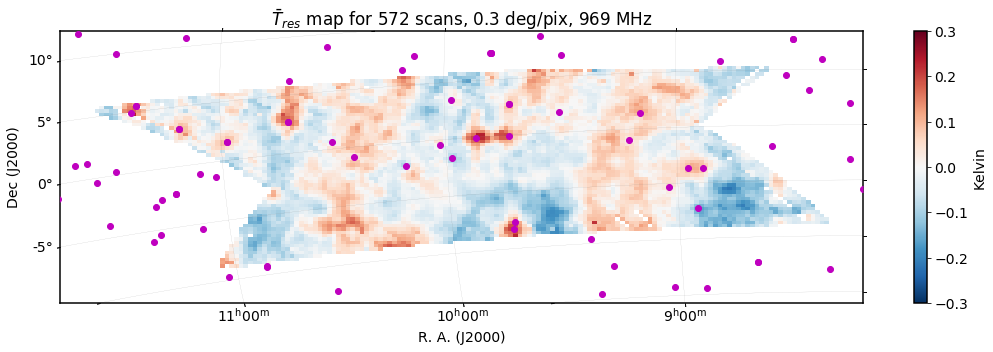

In [19]:
total_count_MAX=1119
niter=3 #2023 
# timestamp = '20250609_150000_500'
input_file='../level5/results/py_results/'
output_file=f'./results/jupyter_results/{timestamp}/'

Fits1=input_file+root_list[-1]+'/'+fname_list[-1]+'_m005/'+fname_list[-1]+'_m005_Tsky_xy_p'+str(pix_deg)+'d.fits'
w=WCS(Fits1).dropaxis(-1)

hdul = fits.open(output_file+f'ALL_scan{total_count_MAX}_Tresi_cube_p'+str(pix_deg)+'d.fits')
Tresi_xy = hdul[0].data
print(Tresi_xy.shape)
hdul.close()

metadata_path = os.path.join(output_file, f"metadata.json")
with open(metadata_path, "r", encoding="utf-8") as f:
    metadata = json.load(f)
total_count_plot = metadata['total_count_plot']

Fits1=input_file+root_list[-1]+'/'+fname_list[-1]+'_m005/'+fname_list[-1]+'_m005_Tsky_xy_p'+str(pix_deg)+'d.fits'
Tsky_cube = fits.open(Fits1)[0].data
Npix_x = np.shape(Tsky_cube)[0]
Npix_y = np.shape(Tsky_cube)[1]

plt.figure(figsize=(18,5))
ax=plt.subplot(projection=w)
plt.grid(color='grey',lw=.1)
plt.imshow(Tresi_xy[:,:,ch_plot].T,cmap=kv.cmap2(),aspect='auto',vmin=-0.3, vmax=0.3)
# plt.imshow(Tresi_xy[:,:,ch_plot].T,cmap=kv.cmap2(),aspect='auto')
plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
#plt.plot(ptr_ra_pix[22],ptr_dec_pix[22],'mo',ms=12)
#plt.text(ptr_ra_pix[19]-0.8,ptr_dec_pix[19]+0.8,'4C+00.35')    

plt.colorbar(label='Kelvin')
plt.xlabel('R. A. (J2000)')
plt.ylabel('Dec (J2000)')
plt.title(r'$\bar T_{res}$'+' map for '+str(total_count_plot)+' scans, '+str(pix_deg)+' deg/pix, '
                              +str(int(kio.cal_freq_UHF(ch_plot)/1e6))+' MHz')
plt.xlim([0,Npix_x])
plt.ylim([0,Npix_y])
ax.invert_xaxis()
plt.show()

In [12]:
print (n_ch_keep,np.sum(total_count_list))
if n_ch_keep==int(np.sum(total_count_list)):
    print ('# n_ch_keep==np.sum(total_count_list)')
else:
    print ('*** n_ch_keep!=np.sum(total_count_list)')

NameError: name 'n_ch_keep' is not defined

In [20]:
# end

# Plot figures

In [8]:
output_file=f'./results/jupyter_results/{timestamp}/'

(173, 81, 4096)
(173, 81, 4096)
(173, 81, 4096)


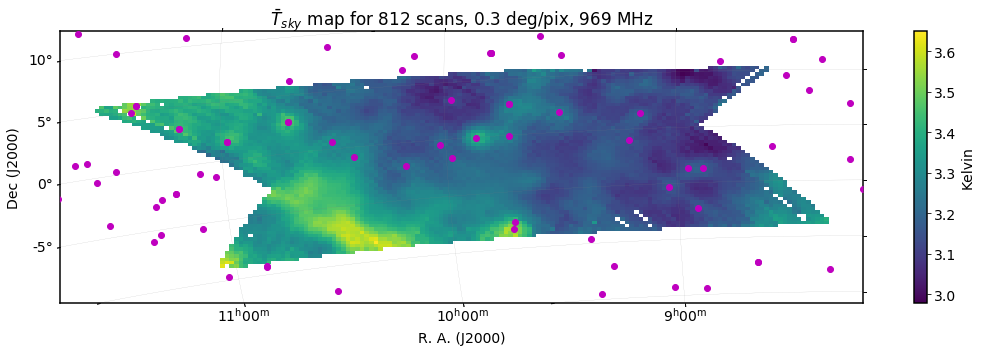

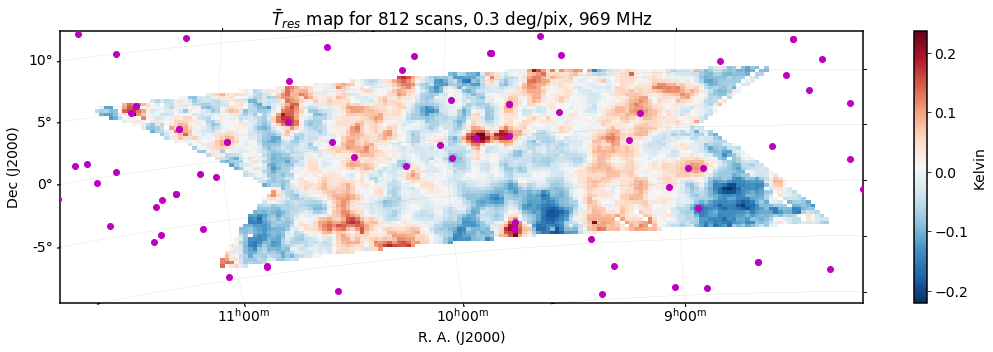

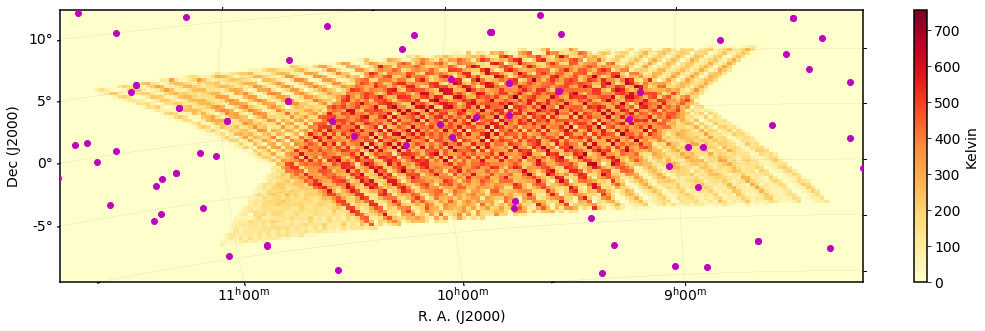

In [25]:
input_file2=output_file
total_count = 1119

Fits0=input_file2+'ALL_scan'+str(total_count)+'_Tsky_cube_p0.3d.fits'
Tsky_ALL = fits.open(Fits0)[0].data
print (np.shape(Tsky_ALL))

Fits1=input_file2+'ALL_scan'+str(total_count)+'_Tresi_cube_p0.3d.fits'
Tresi_ALL = fits.open(Fits1)[0].data
print (np.shape(Tresi_ALL))

Fits2=input_file2+'ALL_scan'+str(total_count)+'_Npix_count_cube_p0.3d.fits'
Count_ALL = fits.open(Fits2)[0].data
print (np.shape(Count_ALL))

# Fits3=input_file2+'ALL_scan'+str(total_count)+'_P_xy_count_p0.3d.fits'
# cube3 = fits.open(Fits3)[0].data
# print (np.shape(cube3))

total_count_plot = 812
Npix_x= np.shape(Count_ALL)[0]
Npix_y= np.shape(Count_ALL)[1]

w=WCS(Fits0).dropaxis(-1)

plt.figure(figsize=(18,5))
ax=plt.subplot(projection=w)
plt.grid(color='grey',lw=.1)
# plt.imshow(Tsky_ALL[:,:,ch_plot].T,cmap=kv.cmap1(),aspect='auto',vmin=2.9,vmax=3.55)
plt.imshow(Tsky_ALL[:,:,ch_plot].T,cmap=kv.cmap1(),aspect='auto')
plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
#plt.plot(ptr_ra_pix[22],ptr_dec_pix[22],'mo',ms=12)
plt.colorbar(label='Kelvin')
plt.xlabel('R. A. (J2000)')
plt.ylabel('Dec (J2000)')
plt.title(r'$\bar T_{sky}$'+' map for '+str(total_count_plot)+' scans, '+str(pix_deg)+' deg/pix, '
                              +str(int(kio.cal_freq_UHF(ch_plot)/1e6))+' MHz')
plt.xlim([0,Npix_x])
plt.ylim([0,Npix_y])
ax.invert_xaxis()
# plt.savefig(output_file+'F_Tsky_ALL_ch'+str(ch_plot)+'_iter0.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(18,5))
ax=plt.subplot(projection=w)
plt.grid(color='grey',lw=.1)
# plt.imshow(Tresi_ALL[:,:,ch_plot].T,cmap=kv.cmap2(),aspect='auto',vmin=-0.25, vmax=0.25)
plt.imshow(Tresi_ALL[:,:,ch_plot].T,cmap=kv.cmap2(),aspect='auto')
plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
#plt.plot(ptr_ra_pix[22],ptr_dec_pix[22],'mo',ms=12)
#plt.text(ptr_ra_pix[19]-0.8,ptr_dec_pix[19]+0.8,'4C+00.35')    

plt.colorbar(label='Kelvin')
plt.xlabel('R. A. (J2000)')
plt.ylabel('Dec (J2000)')
plt.title(r'$\bar T_{res}$'+' map for '+str(total_count_plot)+' scans, '+str(pix_deg)+' deg/pix, '
                              +str(int(kio.cal_freq_UHF(ch_plot)/1e6))+' MHz')
plt.xlim([0,Npix_x])
plt.ylim([0,Npix_y])
ax.invert_xaxis()
# plt.savefig(output_file+'F_Tresi_ALL_ch'+str(ch_plot)+'_iter0.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(18,5))
ax=plt.subplot(projection=w)
plt.grid(color='grey',lw=.1)
plt.imshow(Count_ALL[:,:,ch_plot].T,cmap=kv.cmap3(),aspect='auto')
plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
#plt.plot(ptr_ra_pix[22],ptr_dec_pix[22],'mo',ms=12)
plt.colorbar(label='Kelvin')
plt.xlabel('R. A. (J2000)')
plt.ylabel('Dec (J2000)')
plt.xlim([0,Npix_x])
plt.ylim([0,Npix_y])
ax.invert_xaxis()
# plt.savefig(output_file+'ALL_count'+str(ch_plot)+'_iter0.png', bbox_inches='tight')
plt.show()

(173, 81, 4096)
(173, 81, 4096)
(173, 81, 4096)


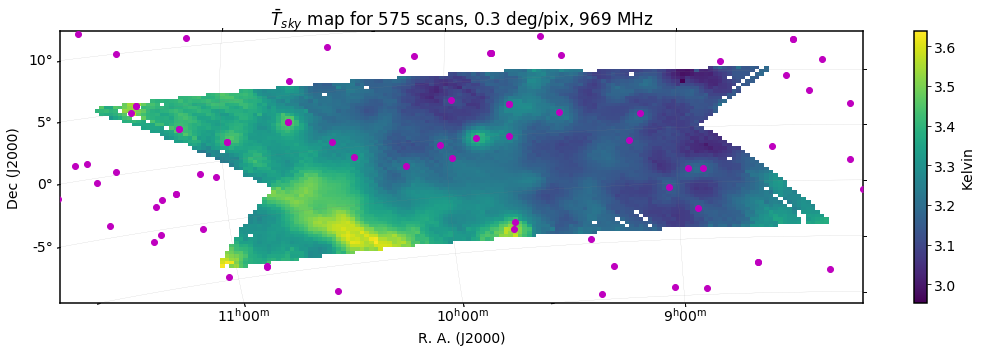

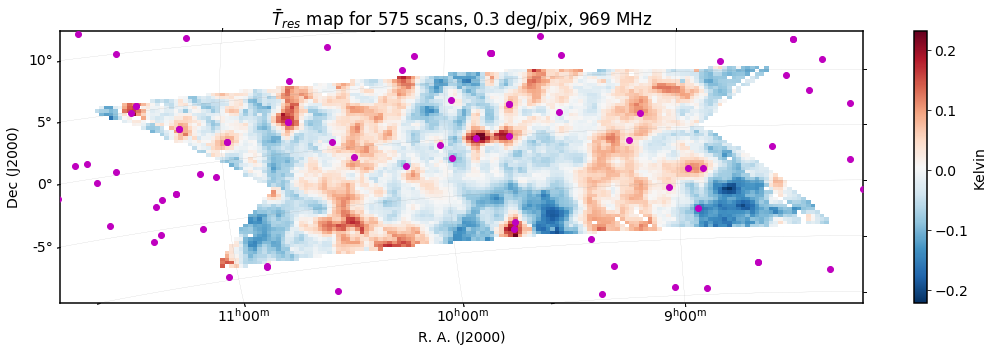

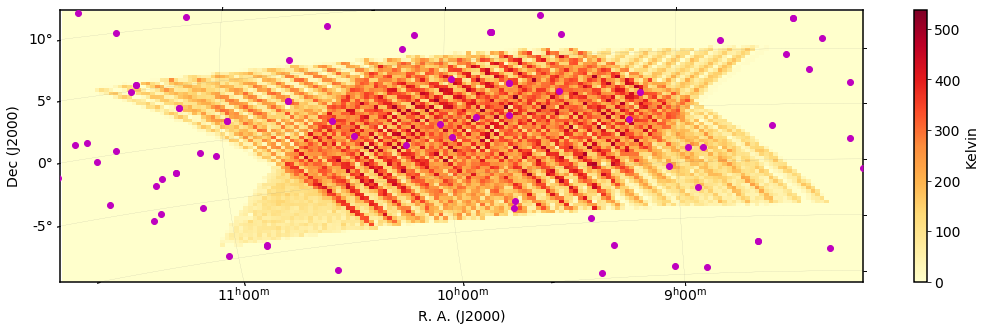

(173, 81, 4096)
(173, 81, 4096)
(173, 81, 4096)


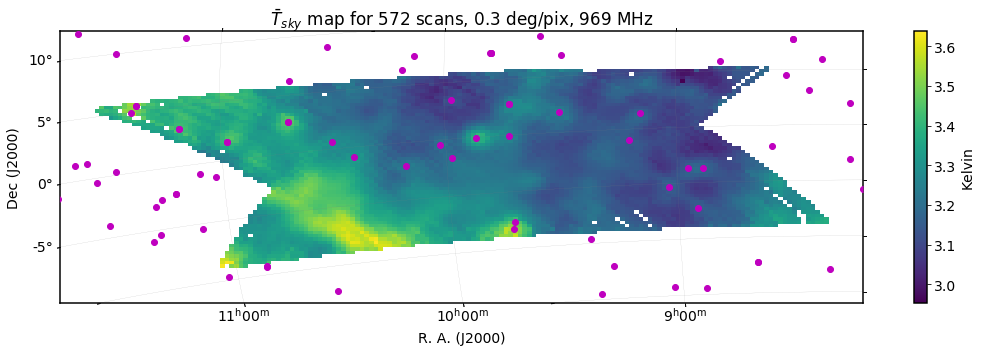

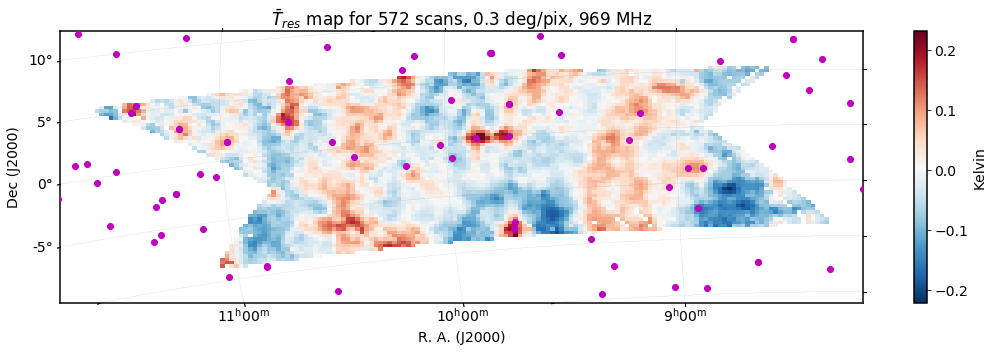

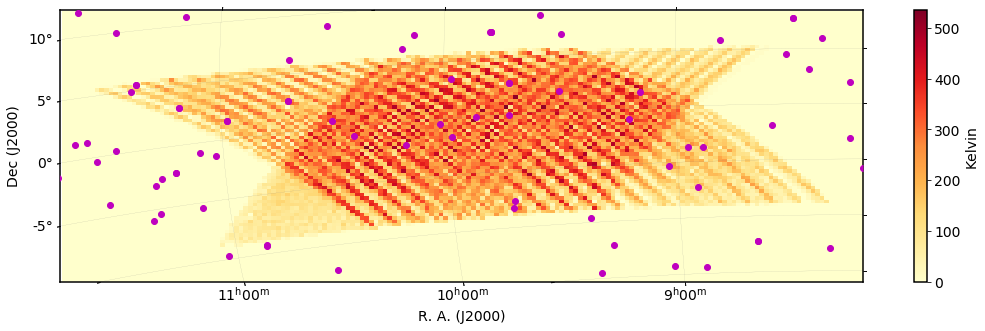

(173, 81, 4096)
(173, 81, 4096)
(173, 81, 4096)


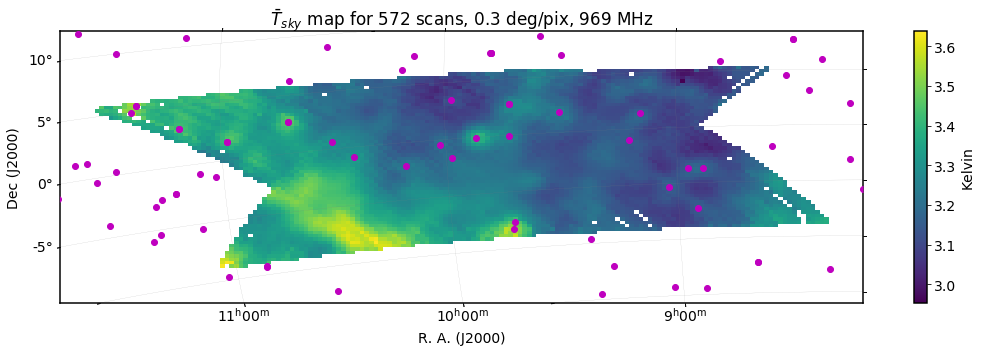

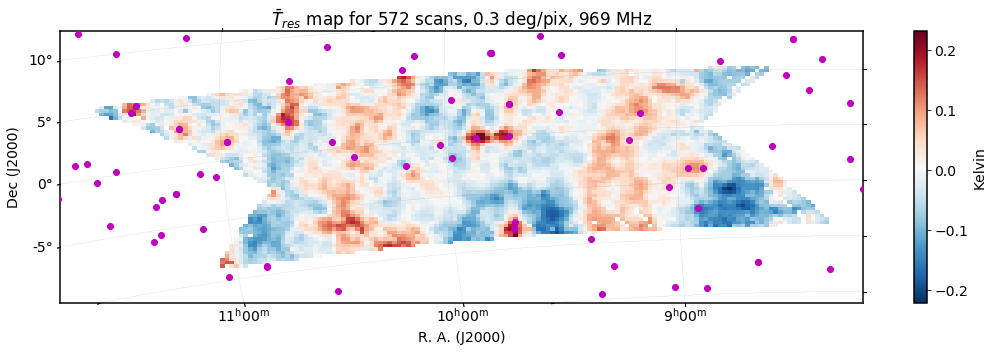

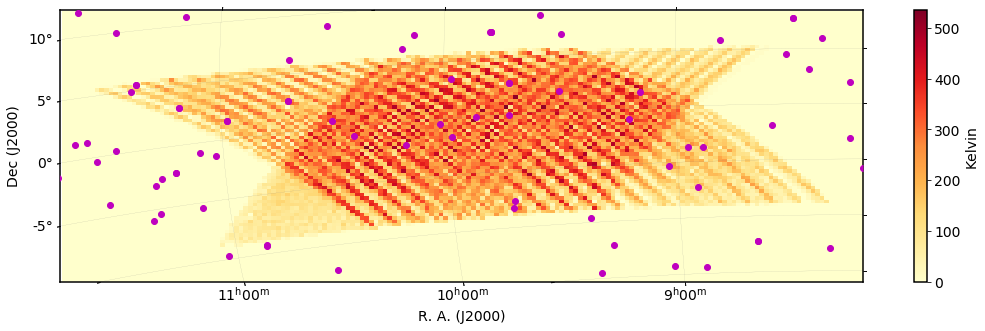

In [26]:
input_file2=output_file
total_count = 1119
niter = 3
total_count_list = [575, 572, 572]

for i_iter in range(niter):
    Fits0=input_file2+'Nscan'+str(total_count)+'_Tsky_cube_p'+str(pix_deg)+'d_sigma'+str(std_sigma)+'_iter'+str(i_iter)+'.fits'
    Tsky_i = fits.open(Fits0)[0].data
    print (np.shape(Tsky_i))
    
    Fits1=input_file2+'Nscan'+str(total_count)+'_Tresi_cube_p'+str(pix_deg)+'d_sigma'+str(std_sigma)+'_iter'+str(i_iter)+'.fits'
    Tresi_i = fits.open(Fits1)[0].data
    print (np.shape(Tresi_i))
    
    Fits2=input_file2+'Nscan'+str(total_count)+'_Npix_count_cube_p'+str(pix_deg)+'d_sigma'+str(std_sigma)+'_iter'+str(i_iter)+'.fits'
    Count_i = fits.open(Fits2)[0].data
    print (np.shape(Count_i))
    
    # Fits3=input_file2+'ALL_scan'+str(total_count)+'_P_xy_count_p0.3d.fits'
    # cube3 = fits.open(Fits3)[0].data
    # print (np.shape(cube3))
    
    total_count_plot = total_count_list[i_iter]
    Npix_x= np.shape(Count_ALL)[0]
    Npix_y= np.shape(Count_ALL)[1]
    
    w=WCS(Fits0).dropaxis(-1)
    
    plt.figure(figsize=(18,5))
    ax=plt.subplot(projection=w)
    plt.grid(color='grey',lw=.1)
    # plt.imshow(Tsky_ALL[:,:,ch_plot].T,cmap=kv.cmap1(),aspect='auto',vmin=2.9,vmax=3.55)
    plt.imshow(Tsky_i[:,:,ch_plot].T,cmap=kv.cmap1(),aspect='auto')
    plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
    #plt.plot(ptr_ra_pix[22],ptr_dec_pix[22],'mo',ms=12)
    plt.colorbar(label='Kelvin')
    plt.xlabel('R. A. (J2000)')
    plt.ylabel('Dec (J2000)')
    plt.title(r'$\bar T_{sky}$'+' map for '+str(total_count_plot)+' scans, '+str(pix_deg)+' deg/pix, '
                                  +str(int(kio.cal_freq_UHF(ch_plot)/1e6))+' MHz')
    plt.xlim([0,Npix_x])
    plt.ylim([0,Npix_y])
    ax.invert_xaxis()
    # plt.savefig(output_file+'F_Tsky_all_ch'+str(ch_plot)+'_iter'+str(i_iter)+'.png', bbox_inches='tight')
    plt.show()
    
    plt.figure(figsize=(18,5))
    ax=plt.subplot(projection=w)
    plt.grid(color='grey',lw=.1)
    # plt.imshow(Tresi_ALL[:,:,ch_plot].T,cmap=kv.cmap2(),aspect='auto',vmin=-0.25, vmax=0.25)
    plt.imshow(Tresi_i[:,:,ch_plot].T,cmap=kv.cmap2(),aspect='auto')
    plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
    #plt.plot(ptr_ra_pix[22],ptr_dec_pix[22],'mo',ms=12)
    #plt.text(ptr_ra_pix[19]-0.8,ptr_dec_pix[19]+0.8,'4C+00.35')    
    
    plt.colorbar(label='Kelvin')
    plt.xlabel('R. A. (J2000)')
    plt.ylabel('Dec (J2000)')
    plt.title(r'$\bar T_{res}$'+' map for '+str(total_count_plot)+' scans, '+str(pix_deg)+' deg/pix, '
                                  +str(int(kio.cal_freq_UHF(ch_plot)/1e6))+' MHz')
    plt.xlim([0,Npix_x])
    plt.ylim([0,Npix_y])
    ax.invert_xaxis()
    # plt.savefig(output_file+'F_Tresi_all_ch'+str(ch_plot)+'_iter'+str(i_iter)+'.png', bbox_inches='tight')
    plt.show()
    
    plt.figure(figsize=(18,5))
    ax=plt.subplot(projection=w)
    plt.grid(color='grey',lw=.1)
    plt.imshow(Count_i[:,:,ch_plot].T,cmap=kv.cmap3(),aspect='auto')
    plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
    #plt.plot(ptr_ra_pix[22],ptr_dec_pix[22],'mo',ms=12)
    plt.colorbar(label='Kelvin')
    plt.xlabel('R. A. (J2000)')
    plt.ylabel('Dec (J2000)')
    plt.xlim([0,Npix_x])
    plt.ylim([0,Npix_y])
    ax.invert_xaxis()
    # plt.savefig(output_file+'Ncount'+str(ch_plot)+'_iter'+str(i_iter)+'.png', bbox_inches='tight')
    plt.show()

# reload data to check 

In [21]:
print (pix_deg, std_sigma, i_iter)

0.3 4.0 0


In [22]:
total_count=1119
i_iter=0

In [23]:
#input_file2='/idia/projects/hi_im/raw_vis/MeerKLASS2021/level6/'
input_file2=output_file

In [32]:
Fits0=input_file2+'ALL_scan'+str(total_count)+'_Tsky_cube_p0.3d.fits'
cube0 = fits.open(Fits0)[0].data
print (np.shape(cube0))

Fits1=input_file2+'ALL_scan'+str(total_count)+'_Tresi_cube_p0.3d.fits'
cube1 = fits.open(Fits1)[0].data
print (np.shape(cube1))

Fits2=input_file2+'ALL_scan'+str(total_count)+'_Npix_count_cube_p0.3d.fits'
cube2 = fits.open(Fits2)[0].data
print (np.shape(cube2))

Fits3=input_file2+'ALL_scan'+str(total_count)+'_P_xy_count_p0.3d.fits'
cube3 = fits.open(Fits3)[0].data
print (np.shape(cube3))

(173, 81, 4096)
(173, 81, 4096)
(173, 81, 4096)


In [25]:
w2=WCS(Fits0).dropaxis(-1)
print (w2)

WCS Transformation

This transformation has 2 pixel and 2 world dimensions

Array shape (Numpy order): (173, 81, 4096)

Pixel Dim  Data size  Bounds
        0       4096  None
        1         81  None

World Dim  Physical Type  Units
        0  pos.eq.ra      deg
        1  pos.eq.dec     deg

Correlation between pixel and world axes:

           Pixel Dim
World Dim    0    1
        0  yes  yes
        1  yes  yes


In [26]:
#check data
assert((cube0[~np.isnan(cube0)]==Tsky_xy[~np.isnan(Tsky_xy)]).all()==True)
print (np.where(Tsky_xy==np.nanmax(Tsky_xy)), np.nanmax(Tsky_xy))
assert((cube1[~np.isnan(cube1)]==Tresi_xy[~np.isnan(Tresi_xy)]).all()==True)
print (np.where(Tresi_xy==np.nanmax(Tresi_xy)), np.nanmax(Tresi_xy))

NameError: name 'Tsky_xy' is not defined

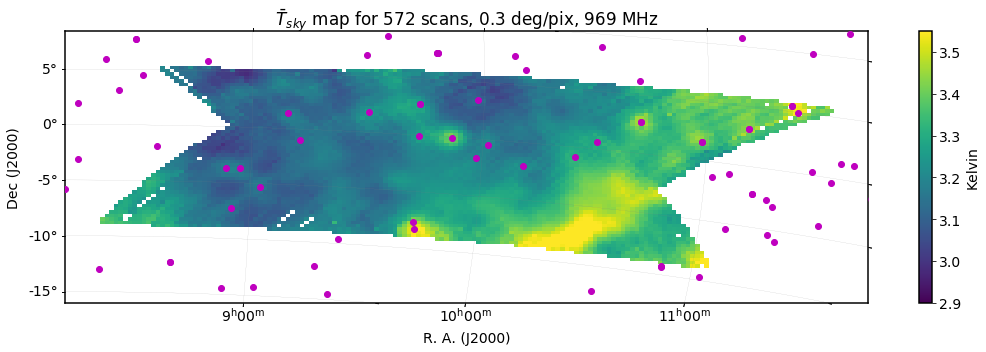

In [27]:
plt.figure(figsize=(18,5))
plt.subplot(projection=w)
plt.grid(color='grey',lw=.1)
plt.imshow(Tsky_xy[:,:,ch_plot].T,cmap=kv.cmap1(),aspect='auto',vmin=2.9,vmax=3.55)
# plt.imshow(cube0[:,:,ch_plot].T,cmap=kv.cmap1(),aspect='auto',vmin=2.9,vmax=3.55)
plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
plt.colorbar(label='Kelvin')
plt.xlabel('R. A. (J2000)')
plt.ylabel('Dec (J2000)')
plt.title(r'$\bar T_{sky}$'+' map for '+str(total_count_plot)+' scans, '+str(pix_deg)+' deg/pix, '
                              +str(int(kio.cal_freq_UHF(ch_plot)/1e6))+' MHz')
plt.xlim([0,Npix_x])
plt.ylim([0,Npix_y])
#plt.savefig('F_Tsky_all_ch'+str(ch_plot)+'_iter'+str(i_iter)+'.pdf', bbox_inches='tight')
plt.show()


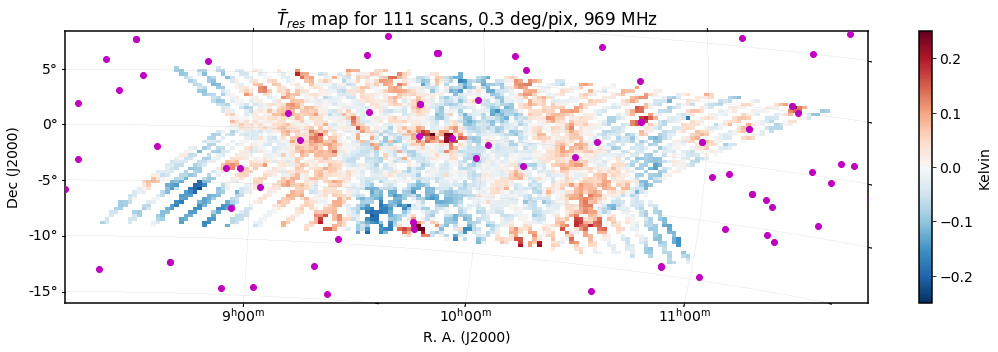

In [45]:

plt.figure(figsize=(18,5))
plt.subplot(projection=w)
plt.grid(color='grey',lw=.1)
plt.imshow(Tresi_xy[:,:,ch_plot].T,cmap=kv.cmap2(),aspect='auto',vmin=-0.25,vmax=0.25)
plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
#plt.plot(ptr_ra_pix[22],ptr_dec_pix[22],'mo',ms=12)
plt.colorbar(label='Kelvin')
plt.xlabel('R. A. (J2000)')
plt.ylabel('Dec (J2000)')
plt.title(r'$\bar T_{res}$'+' map for '+str(total_count_plot)+' scans, '+str(pix_deg)+' deg/pix, '
                              +str(int(kio.cal_freq_UHF(ch_plot)/1e6))+' MHz')
plt.xlim([0,Npix_x])
plt.ylim([0,Npix_y])
#plt.savefig('F_Tsky_all_ch'+str(ch_plot)+'_iter'+str(i_iter)+'.pdf', bbox_inches='tight')
plt.show()


In [28]:
total_count_plot1=total_count

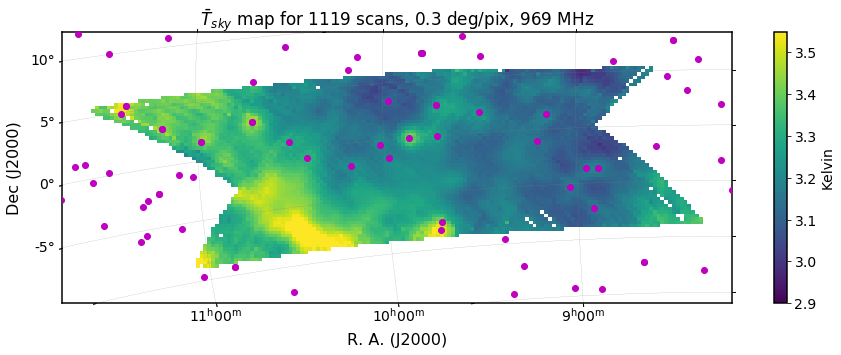

In [31]:
plt.figure(figsize=(15,5))
ax=plt.subplot(projection=w2)
plt.grid(color='grey',lw=.15)
plt.imshow(cube0[:,:,ch_plot].T,cmap=kv.cmap1(),aspect='auto', vmin=2.9,vmax=3.55)
plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
plt.colorbar(label='Kelvin')
plt.xlabel('R. A. (J2000)',fontsize=16)
plt.ylabel('Dec (J2000)',fontsize=16)
plt.title(r'$\bar T_{sky}$'+' map for '+str(total_count_plot1)+' scans, '+str(pix_deg)+' deg/pix, '
                               +str(int(kio.cal_freq_UHF(ch_plot)/1e6))+' MHz')
plt.xlim([0,Npix_x])
plt.ylim([0,Npix_y])
ax.invert_xaxis()
# plt.savefig('ALL2.png', bbox_inches='tight')
plt.show()

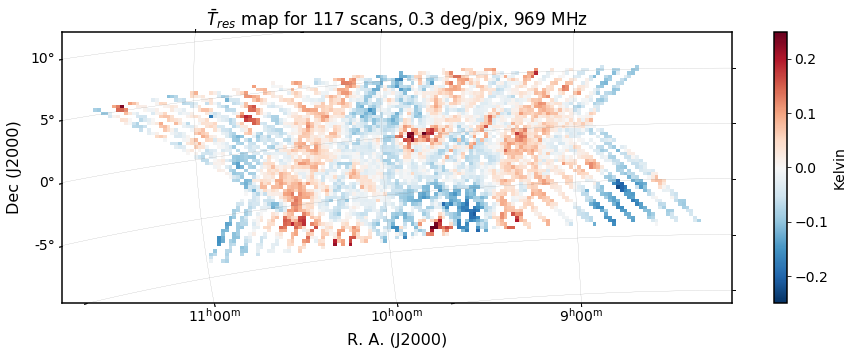

In [50]:
plt.figure(figsize=(15,5))
ax=plt.subplot(projection=w2)
plt.grid(color='grey',lw=.15)
plt.imshow(cube1[:,:,ch_plot].T,cmap=kv.cmap2(),aspect='auto', vmin=-0.25,vmax=0.25)
#plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
plt.colorbar(label='Kelvin')
plt.xlabel('R. A. (J2000)',fontsize=16)
plt.ylabel('Dec (J2000)',fontsize=16)
plt.title(r'$\bar T_{res}$'+' map for '+str(total_count_plot1)+' scans, '+str(pix_deg)+' deg/pix, '
                                  +str(int(kio.cal_freq_UHF(ch_plot)/1e6))+' MHz')
# plt.xlim([15,Npix_x-15])
# plt.ylim([0,Npix_y])
ax.invert_xaxis()
plt.savefig('ALL2.png', bbox_inches='tight')
plt.show()

In [51]:
aa=cube1[:,:,ch_plot]
aa=aa[~np.isnan(aa)]
print (np.shape(aa))
print (np.mean(aa))

(3997,)
-0.0032932415584295037


In [52]:
rms1 = np.sqrt(np.mean(np.square(aa)))
print (rms1)
print (str(round(rms1*1e3,2))+' mK')

0.06478200410406788
64.78 mK


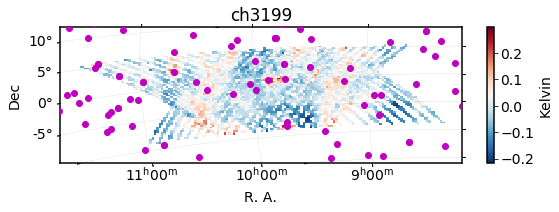

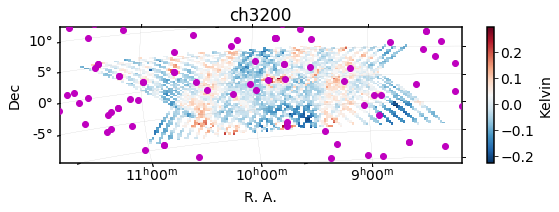

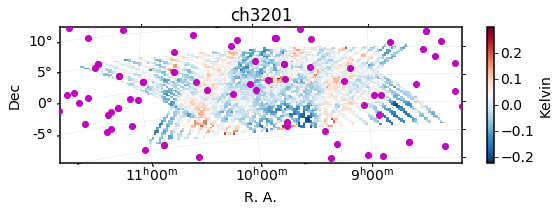

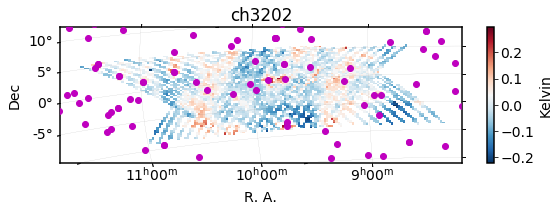

In [53]:
for ch_i in [ch_plot-1,ch_plot,ch_plot+1,ch_plot+2]:
    plt.figure(figsize=(9,2.5))
    ax=plt.subplot(projection=w2)
    plt.grid(color='grey',lw=.1)
    plt.imshow(cube1[:,:,ch_i].T,cmap=kv.cmap2(),aspect='auto')#, vmin=-0.25,vmax=0.25)
    plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
    plt.colorbar(label='Kelvin')
    plt.xlabel('R. A.')
    plt.ylabel('Dec')
    plt.xlim([0,Npix_x])
    plt.ylim([0,Npix_y])
    plt.title('ch'+str(ch_i))
    ax.invert_xaxis()
    #plt.plot('test B')
    plt.show()

In [54]:
#ABBA 
bb0=(cube0[:,:,ch_plot]+cube0[:,:,ch_plot+1])/2.-(cube0[:,:,ch_plot-1]+cube0[:,:,ch_plot+2])/2.
bb1=(cube1[:,:,ch_plot]+cube1[:,:,ch_plot+1])/2.-(cube1[:,:,ch_plot-1]+cube1[:,:,ch_plot+2])/2.

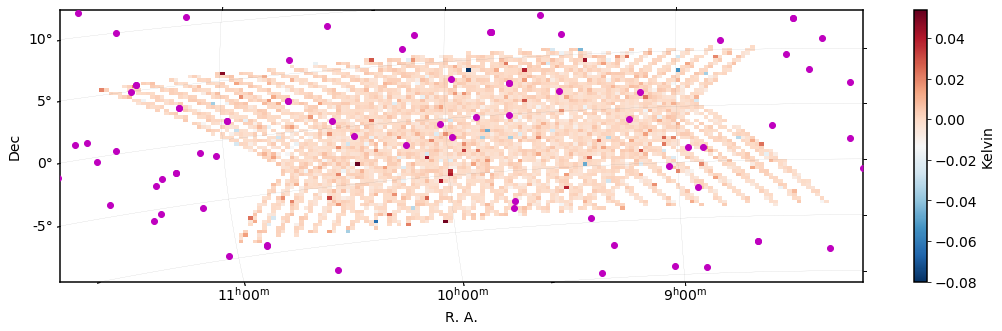

In [55]:
plt.figure(figsize=(18,5))
ax=plt.subplot(projection=w2)
plt.grid(color='grey',lw=.1)
plt.imshow(bb0.T,cmap=kv.cmap2(),aspect='auto')
plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
plt.colorbar(label='Kelvin')
plt.xlabel('R. A.')
plt.ylabel('Dec')
plt.xlim([0,Npix_x])
plt.ylim([0,Npix_y])
ax.invert_xaxis()
#plt.plot('test B')
plt.show()

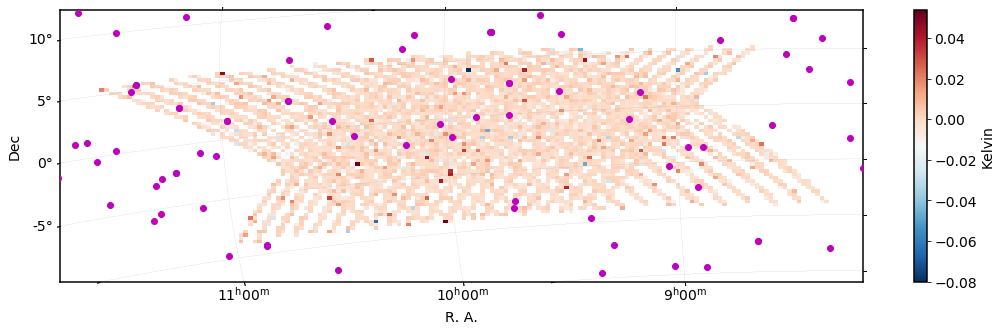

In [56]:
plt.figure(figsize=(18,5))
ax=plt.subplot(projection=w2)
plt.grid(color='grey',lw=.1)
plt.imshow(bb1.T,cmap=kv.cmap2(),aspect='auto')
plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
plt.colorbar(label='Kelvin')
plt.xlabel('R. A.')
plt.ylabel('Dec')
plt.xlim([0,Npix_x])
plt.ylim([0,Npix_y])
ax.invert_xaxis()
#plt.plot('test B')
plt.show()

In [57]:
bb0=bb0[~np.isnan(bb0)]
print (np.shape(bb0))
print (np.mean(bb0))

(3997,)
-4.7331674348641724e-05


In [58]:
rms2 = np.sqrt(np.mean(np.square(bb0)))
print (rms2)
print (str(round(rms2*1e3,2))+' mK')

0.00574370142958737
5.74 mK


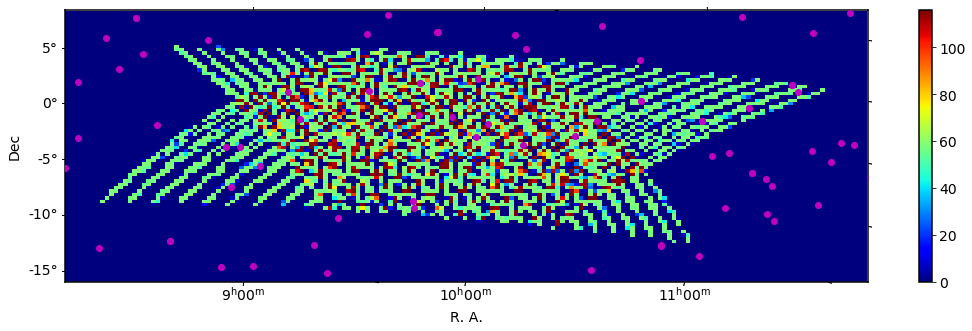

In [59]:
plt.figure(figsize=(18,5))
plt.subplot(projection=w2)
plt.imshow(cube2[:,:,ch_plot].T,cmap='jet',aspect='auto')
plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
plt.colorbar()
plt.xlabel('R. A.')
plt.ylabel('Dec')
plt.xlim([0,Npix_x])
plt.ylim([0,Npix_y])
plt.show()

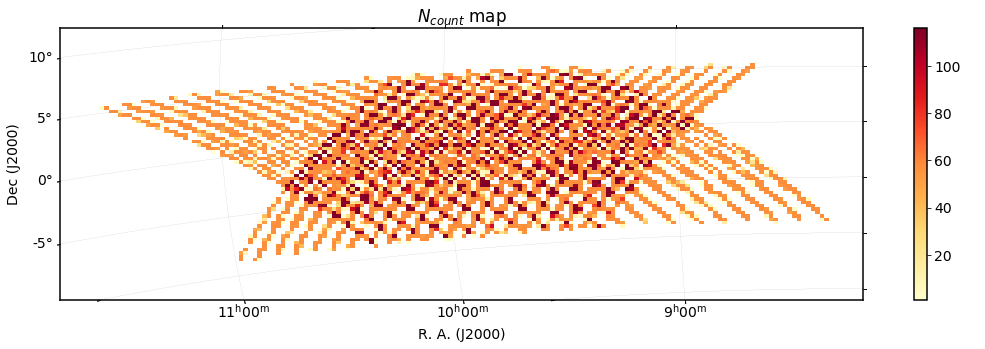

In [60]:
map_2=cube2.copy() #Ncount
map_22=np.ma.array(map_2,mask=True)
map_22.mask[~np.isnan(map_2)]=False
map_22.mask[map_2==0]=True

plt.figure(figsize=(18,5))
ax=plt.subplot(projection=w)
plt.grid(color='grey',lw=.1)
plt.imshow(map_22[:,:,ch_plot].T,cmap='YlOrRd', aspect='auto')
#plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
#plt.plot(ptr_ra_pix[22],ptr_dec_pix[22],'mo',ms=12)
plt.colorbar(label='  ')
plt.xlabel('R. A. (J2000)')
plt.ylabel('Dec (J2000)')
plt.xlim([0,Npix_x])
plt.ylim([0,Npix_y])
ax.invert_xaxis()
plt.title(r'$N_{count}$'+' map')
plt.savefig('Ncount_'+str(ch_plot)+'_final.pdf', bbox_inches='tight')
plt.show()


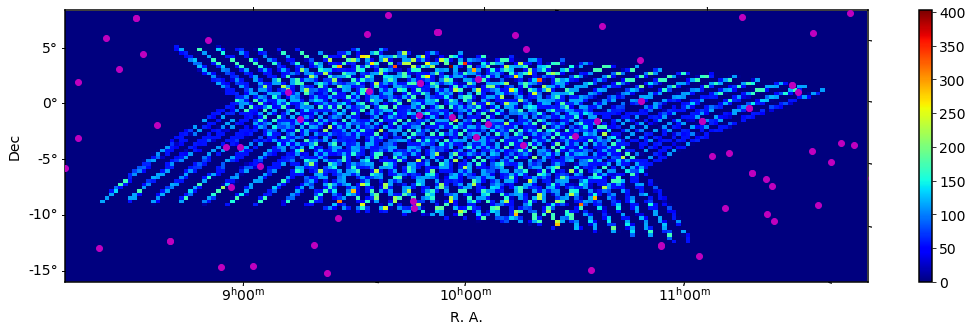

In [61]:
plt.figure(figsize=(18,5))
plt.subplot(projection=w2)
plt.imshow(cube3[:,:,ch_plot].T,cmap='jet',aspect='auto')
plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
plt.colorbar()
plt.xlabel('R. A.')
plt.ylabel('Dec')
plt.xlim([0,Npix_x])
plt.ylim([0,Npix_y])
plt.show()

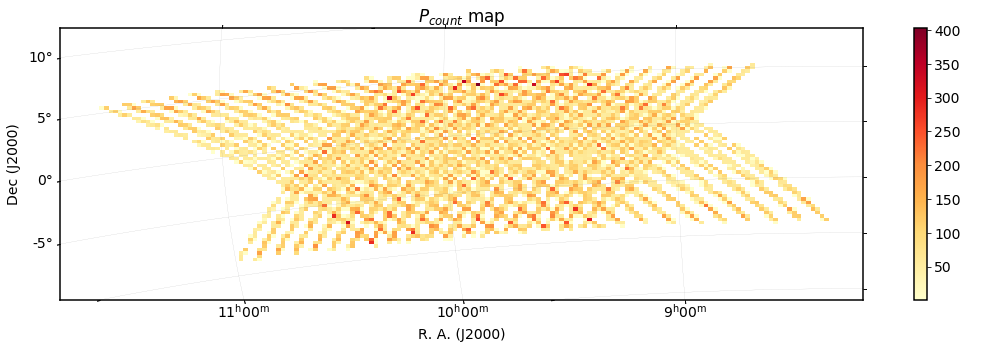

In [62]:
map_3=cube3.copy() #Ncount
map_33=np.ma.array(map_3,mask=True)
map_33.mask[~np.isnan(map_3)]=False
map_33.mask[map_3==0]=True

plt.figure(figsize=(18,5))
ax=plt.subplot(projection=w)
plt.grid(color='grey',lw=.1)
plt.imshow(map_33[:,:,ch_plot].T,cmap=kv.cmap3(), aspect='auto')
#plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
#plt.plot(ptr_ra_pix[22],ptr_dec_pix[22],'mo',ms=12)
plt.colorbar(label='  ')
plt.xlabel('R. A. (J2000)')
plt.ylabel('Dec (J2000)')
plt.xlim([0,Npix_x])
plt.ylim([0,Npix_y])
ax.invert_xaxis()
plt.title(r'$P_{count}$'+' map')
plt.savefig('Pcount_'+str(ch_plot)+'_final.pdf', bbox_inches='tight')
plt.show()


In [63]:
#test below

Text(0,0.5,'scan count')

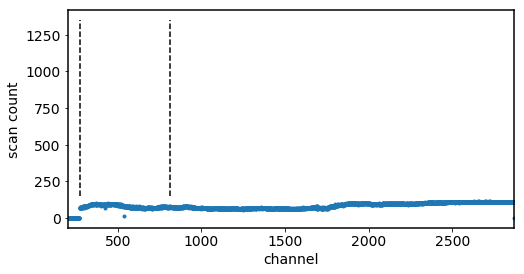

In [64]:
plt.figure(figsize=(8,4))
plt.plot(total_count_list,'.')
plt.plot(ch_plot,total_count_plot,'r*')
plt.xlim(200,2868)
plt.plot([272,272],[150,1350],'k--')
plt.plot([810,810],[150,1350],'k--')
plt.xlabel('channel')
plt.ylabel('scan count')

In [65]:
print (kio.cal_freq_UHF(272)/1e6,kio.cal_freq_UHF(810)/1e6)

580.125 651.578125


In [66]:
total_count

117

In [67]:
freqs=kio.cal_freqs_UHF(range(4096))
freqs = np.array(freqs)

In [68]:
total_count_list0=np.loadtxt(output_file+'ALL_scan'+str(total_count)+'_list_p'+str(pix_deg)+'d.dat')
#scan_count_list=np.loadtxt('Nscan366_list_p0.3d_sigma2.5_iter2.dat')
scan_count_list=np.loadtxt('ALL_scan966_list_p0.3d.dat')
plt.figure(figsize=(8,5))
plt.plot([freqs[0]/1e6,freqs[-1]/1e6],[total_count,total_count], 'k--')
plt.plot(freqs/1e6, total_count_list0,'.',color='grey')
plt.plot(freqs/1e6, scan_count_list,'.')
plt.legend(['total number of scans (966)','number of calibrated scans in each channel', 'number of scans after weak RFI flagging'],fontsize=14)
#plt.ylim(0,530)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Count')
plt.savefig('F_count_comp_final.pdf', bbox_inches='tight')
plt.show()

OSError: ALL_scan966_list_p0.3d.dat not found.

In [ ]:
for i in range(4096):
    plt.plot(kio.cal_freq_UHF(i)/1e6, scan_count_list[i]/total_count,'.')
plt.show()    

In [ ]:
a_dat=[]
for i in range(4096):
    a_dat.append([kio.cal_freq_UHF(i)/1e6, scan_count_list[i]/total_count])
a_dat=np.array(a_dat)

np.savetxt('freq_MHz_vs_good_scan_ratio.dat',a_dat)
    

In [ ]:
a_list=np.loadtxt('freq_MHz_vs_good_scan_ratio.dat')

In [ ]:
(a_dat==a_list).all()

In [ ]:
plt.plot(a_list[:,0],a_list[:,1],'.')
plt.show()

In [ ]:
#test above

# the Galactic model

In [ ]:
nside=64 #healpix nside, 64: Mean Spacing (deg) is 0.9161
import pysm
from pysm.nominal import models


In [ ]:
def cal_Gal_pix (pix_ra, pix_dec, freq, nside):
    sky_config = {
        'synchrotron': models("s1", nside),
    }

    sky = pysm.Sky(sky_config)
    
    c = SkyCoord(ra=pix_ra * u.degree, dec=pix_dec * u.degree, frame='icrs')
    theta = 90 - (c.galactic.b / u.degree).value
    phi = (c.galactic.l / u.degree).value
        
    syn = sky.synchrotron(nu=freq/1e9) / 1e6  # K
    I = hp.pixelfunc.get_interp_val(syn[0, :], theta / 180 * np.pi, phi / 180 * np.pi)
        
    return I


In [ ]:
total_count=total_count
model_key=0 #0 for full band count, to achieve a good sky coverage; 
            #1 for Tresi map, to have same coverage as Tresi in certain channel

if model_key==1:
    #Fits='/idia/projects/hi_im/raw_vis/katcali_output/level6_output/p'+str(pix_deg)+'d/p'+str(pix_deg)+'d_sigma'+str(std_sigma)+'_iter'+str(i_iter)+'/Nscan'+str(total_count)+'_Tresi_cube_p'+str(pix_deg)+'d_sigma'+str(std_sigma)+'_iter'+str(i_iter)+'.fits'
    Fits='ALL_scan966_Tresi_cube_p0.3d.fits'
    cube = fits.open(Fits)[0].data
    print (np.shape(cube))
    a=np.where(~np.isnan(cube[:,:,ch_plot]))
    print (np.shape(a))
    
if model_key==0:
    #Fits='/idia/projects/hi_im/raw_vis/katcali_output/level6_output/p0.3d/ALL/ALL_scan366_Npix_count_cube_p0.3d.fits'
    Fits='ALL_scan966_Npix_count_cube_p0.3d.fits'
    cube = fits.open(Fits)[0].data
    print (np.shape(cube))
    #cube1=np.sum(cube,axis=2)
    cube1=cube[:,:,ch_plot]
    a=np.where(cube1>0)
    print (np.shape(a))

In [ ]:

pix_list_x=np.array(a[0])
pix_list_y=np.array(a[1])

In [ ]:
pix_radec=pixel_to_skycoord(pix_list_x,pix_list_y,w)
pix_ra,pix_dec=(pix_radec.ra/u.deg).value,(pix_radec.dec/u.deg).value

In [ ]:
gal_pix=np.zeros([Npix_x,Npix_y])
gal_pix[pix_list_x,pix_list_y]=cal_Gal_pix (pix_ra, pix_dec, kio.cal_freq_UHF(ch_plot), nside)    

if model_key==1: #1 for Tresi map, to have same coverage as Tresi in certain channel
    gal_pix[np.isnan(cube[:,:,ch_plot])]=np.nan
if model_key==0: #0 for full band count, to achieve a good sky coverage; 
    gal_pix[np.where(cube1==0)]=np.nan



In [ ]:
Tcmb

In [ ]:
plt.figure(figsize=(18,5))
ax=plt.subplot(projection=w)
plt.grid(color='grey',lw=.1)
plt.imshow(gal_pix.T,cmap=kv.cmap1(),aspect='auto',vmin=2.9-Tcmb,vmax=3.55-Tcmb)
#plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
#plt.plot(ptr_ra_pix[22],ptr_dec_pix[22],'mo',ms=12)
plt.colorbar(label='Kelvin')
plt.xlabel('R. A. (J2000)')
plt.ylabel('Dec (J2000)')
plt.title('Galactic model at '+str(int(kio.cal_freq_UHF(ch_plot)/1e6))+' MHz')
plt.xlim([0,Npix_x])
plt.ylim([0,Npix_y])
ax.invert_xaxis()
plt.savefig('F_Tgal_model_ch'+str(ch_plot)+'.pdf', bbox_inches='tight')
plt.show()

In [ ]:
print ('end @ ' + time.asctime(time.localtime(time.time())) +'#')